In [1]:
from importlib.metadata import version, PackageNotFoundError

import torch, torchvision, timm, sklearn, PIL, cv2
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("timm:", timm.__version__)
print("scikit-learn:", sklearn.__version__)
print("Pillow:", PIL.__version__)
print("opencv:", cv2.__version__)

try:
    print("grad-cam:", version("grad-cam"))
except PackageNotFoundError:
    print("grad-cam: NOT INSTALLED (run: pip install grad-cam)")


torch: 2.8.0+cu126
torchvision: 0.23.0+cu126
timm: 1.0.19
scikit-learn: 1.6.1
Pillow: 11.3.0
opencv: 4.12.0
grad-cam: NOT INSTALLED (run: pip install grad-cam)


In [2]:
from pathlib import Path
import json, random, time

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
import random, numpy as np, torch
import torch.backends.cudnn as cudnn

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
cudnn.deterministic = True
cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", DEVICE)


device: cuda


In [5]:
# Download EuroSAT into /content/data and detect the actual folder name
from pathlib import Path
from torchvision import datasets, transforms

DATA_ROOT = Path("data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# download (RGB)
_ = datasets.EuroSAT(root=str(DATA_ROOT), download=True, transform=transforms.ToTensor())

# handle both possible names created by torchvision
CANDIDATES = [DATA_ROOT / "EuroSAT", DATA_ROOT / "eurosat"]
BASE = next((p for p in CANDIDATES if p.exists()), None)
assert BASE is not None, f"EuroSAT folder not found under {CANDIDATES}"

IMG_DIR = BASE / "2750"
assert IMG_DIR.exists(), f"Missing folder: {IMG_DIR}"

classes = sorted([d.name for d in IMG_DIR.iterdir() if d.is_dir()])
print("dataset root:", BASE.resolve())
print("classes (should be 10):", classes)
print("total images (approx):", sum(1 for _ in IMG_DIR.rglob('*.jpg')))


100%|██████████| 94.3M/94.3M [00:00<00:00, 235MB/s]


dataset root: /content/data/eurosat
classes (should be 10): ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
total images (approx): 27000


In [7]:
# Build a dataframe listing each image file and its label

IMG_DIR = BASE / "2750"  # from the previous cell
rows = []
for class_dir in sorted([d for d in IMG_DIR.iterdir() if d.is_dir()]):
    label = class_dir.name
    for img in class_dir.glob("*.jpg"):
        rows.append({"filepath": str(img.resolve()), "label": label})

df = pd.DataFrame(rows)
print("Total images:", len(df))
df.head()


Total images: 27000


,filepath,label
0,/content/data/eurosat/2750/AnnualCrop/AnnualCr...,AnnualCrop
1,/content/data/eurosat/2750/AnnualCrop/AnnualCr...,AnnualCrop
2,/content/data/eurosat/2750/AnnualCrop/AnnualCr...,AnnualCrop
3,/content/data/eurosat/2750/AnnualCrop/AnnualCr...,AnnualCrop
4,/content/data/eurosat/2750/AnnualCrop/AnnualCr...,AnnualCrop


In [8]:
SEED = 42
test_size = 0.10       # 10% test
val_size  = 0.10       # 10% val (of the whole dataset)

# 1) hold out test
train_val, test = train_test_split(
    df, test_size=test_size, stratify=df["label"], random_state=SEED
)
# 2) from the remaining, hold out val so overall val ≈ 10%
val_ratio_adjusted = val_size / (1 - test_size)
train, val = train_test_split(
    train_val, test_size=val_ratio_adjusted, stratify=train_val["label"], random_state=SEED
)

# save
SPLITS = Path("splits"); SPLITS.mkdir(parents=True, exist_ok=True)
train.to_csv(SPLITS / "train.csv", index=False)
val.to_csv(SPLITS / "val.csv", index=False)
test.to_csv(SPLITS / "test.csv", index=False)

# quick checks
print("sizes (train/val/test):", len(train), len(val), len(test))  # ~21600 / 2700 / 2700
set_train, set_val, set_test = set(train["filepath"]), set(val["filepath"]), set(test["filepath"])
print("overlaps train∩val/train∩test/val∩test:",
      len(set_train & set_val), len(set_train & set_test), len(set_val & set_test))
print("\ntrain counts (first 5 classes):\n", train["label"].value_counts().sort_index().head())

sizes (train/val/test): 21600 2700 2700
overlaps train∩val/train∩test/val∩test: 0 0 0

train counts (first 5 classes):
 label
AnnualCrop              2400
Forest                  2400
HerbaceousVegetation    2400
Highway                 2000
Industrial              2000
Name: count, dtype: int64


In [9]:
from torchvision import transforms
from PIL import Image
import torch

# ImageNet normalization (for pretrained ResNet/EfficientNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# quick smoke test on one training image
sample_path = train.sample(1, random_state=42)["filepath"].item()
x = train_tf(Image.open(sample_path).convert("RGB"))
print("tensor shape:", tuple(x.shape))  # expect (3, 224, 224)
print("value range (min/max):", float(x.min()), float(x.max()))


tensor shape: (3, 224, 224)
value range (min/max): -2.1179039478302 0.4787801504135132


In [10]:
from pathlib import Path
import json
from PIL import Image
from torch.utils.data import Dataset

# label ↔ index maps (from your train split)
classes = sorted(train["label"].unique())
label2idx = {c:i for i,c in enumerate(classes)}
idx2label = {i:c for c,i in label2idx.items()}

# save for later (Streamlit app will reuse)
Path("assets").mkdir(exist_ok=True)
(Path("assets")/"label2idx.json").write_text(json.dumps(label2idx, indent=2))
(Path("assets")/"idx2label.json").write_text(json.dumps(idx2label, indent=2))

# dataset that reads from our CSVs
class CSVDataset(Dataset):
    def __init__(self, frame, transform, l2i):
        self.df = frame.reset_index(drop=True)
        self.tf = transform
        self.l2i = l2i
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r["filepath"]).convert("RGB")
        x = self.tf(img)
        y = self.l2i[r["label"]]
        return x, y

# build datasets
train_ds = CSVDataset(train, train_tf, label2idx)
val_ds   = CSVDataset(val,   eval_tf,  label2idx)
test_ds  = CSVDataset(test,  eval_tf,  label2idx)

len(train_ds), len(val_ds), len(test_ds)


(21600, 2700, 2700)

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# quick check
xb, yb = next(iter(train_dl))
print("batch X:", tuple(xb.shape))
print("batch y:", tuple(yb.shape), "min/max labels:", int(yb.min()), int(yb.max()))


batch X: (32, 3, 224, 224)
batch y: (32,) min/max labels: 0 9


In [12]:
import torch
from torch import nn
from torchvision import models

num_classes = len(label2idx)

# Load ImageNet weights (fallback to random init if download blocked)
try:
    weights = models.ResNet50_Weights.IMAGENET1K_V2
    model = models.resnet50(weights=weights)
except Exception as e:
    print("Using random init (couldn't load pretrained):", e)
    model = models.resnet50(weights=None)

# Replace the final layer for our 10 classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(DEVICE)

# Loss + optimizer (lower LR for backbone, higher for new head)
criterion = nn.CrossEntropyLoss()
backbone_params = [p for n,p in model.named_parameters() if not n.startswith("fc.")]
head_params     = [p for n,p in model.named_parameters() if n.startswith("fc.")]
optimizer = torch.optim.AdamW(
    [{"params": backbone_params, "lr": 1e-4},
     {"params": head_params,     "lr": 1e-3}]
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

# Quick forward sanity check
xb, yb = next(iter(train_dl))
with torch.no_grad():
    logits = model(xb.to(DEVICE))
print("logits shape:", tuple(logits.shape))
print("device:", DEVICE, "| num_classes:", num_classes)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


logits shape: (32, 10)
device: cuda | num_classes: 10


In [13]:
import time
from pathlib import Path
from torch.cuda.amp import autocast, GradScaler

EPOCHS = 2                      # keep small for a first run
CKPT_DIR = Path("checkpoints"); CKPT_DIR.mkdir(exist_ok=True)
BEST_PATH = CKPT_DIR / "best_resnet50.pt"

scaler = GradScaler(enabled=(DEVICE == "cuda"))
best_val_acc = 0.0

def run_epoch(dl, train_mode: bool):
    model.train(mode=train_mode)
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train_mode):
            with autocast(enabled=(DEVICE == "cuda")):
                logits = model(xb)
                loss = criterion(logits, yb)
        if train_mode:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)
        loss_sum += loss.item() * yb.size(0)
    return loss_sum/total, correct/total

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_dl, True)
    val_loss, val_acc = run_epoch(val_dl,   False)
    scheduler.step()
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"train {tr_loss:.4f}/{tr_acc:.3f} | "
          f"val {val_loss:.4f}/{val_acc:.3f} | "
          f"{time.time()-t0:.1f}s")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model": model.state_dict(), "classes": sorted(label2idx.keys())}, BEST_PATH)
        print("  ↳ saved best:", BEST_PATH, f"(val_acc={best_val_acc:.3f})")


/tmp/ipython-input-3678034348.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE == "cuda"))
/tmp/ipython-input-3678034348.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE == "cuda")):


Epoch 1/2 | train 0.2531/0.918 | val 0.0846/0.973 | 109.5s
  ↳ saved best: checkpoints/best_resnet50.pt (val_acc=0.973)
Epoch 2/2 | train 0.0929/0.968 | val 0.0738/0.973 | 106.1s
  ↳ saved best: checkpoints/best_resnet50.pt (val_acc=0.973)


In [14]:
import numpy as np
from sklearn.metrics import classification_report

# load best weights
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

# predict on test
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        logits = model(xb)
        y_pred.extend(logits.argmax(1).cpu().numpy().tolist())
        y_true.extend(yb.numpy().tolist())

classes_sorted = sorted(label2idx.keys())
test_acc = (np.array(y_true) == np.array(y_pred)).mean()
print(f"TEST accuracy: {test_acc:.3f}\n")
print(classification_report(y_true, y_pred, target_names=classes_sorted, digits=3))


TEST accuracy: 0.977

                      precision    recall  f1-score   support

          AnnualCrop      0.973     0.960     0.966       300
              Forest      0.980     0.993     0.987       300
HerbaceousVegetation      0.937     0.983     0.959       300
             Highway      1.000     0.964     0.982       250
          Industrial      0.992     0.972     0.982       250
             Pasture      0.980     0.965     0.972       200
       PermanentCrop      0.971     0.948     0.960       250
         Residential      0.977     0.993     0.985       300
               River      0.969     0.992     0.980       250
             SeaLake      0.997     0.987     0.992       300

            accuracy                          0.977      2700
           macro avg      0.978     0.976     0.976      2700
        weighted avg      0.977     0.977     0.977      2700



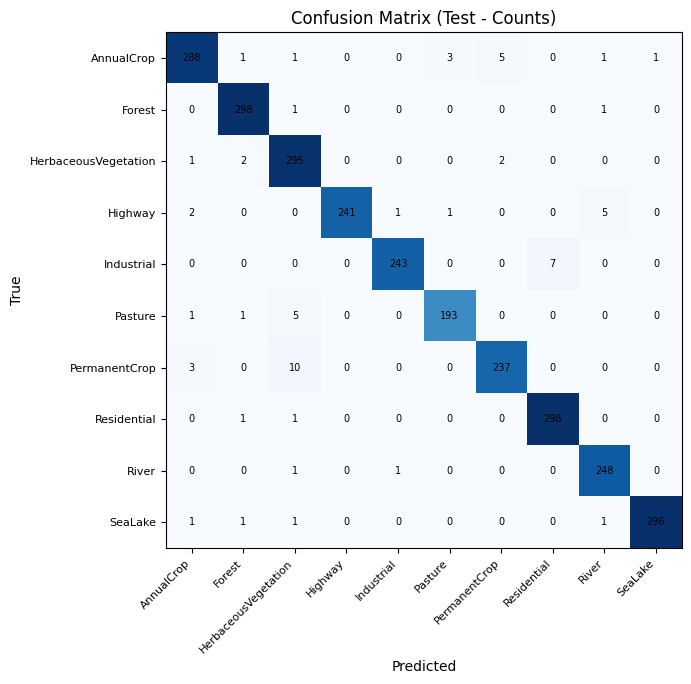

Saved: confusion_matrix_raw.png


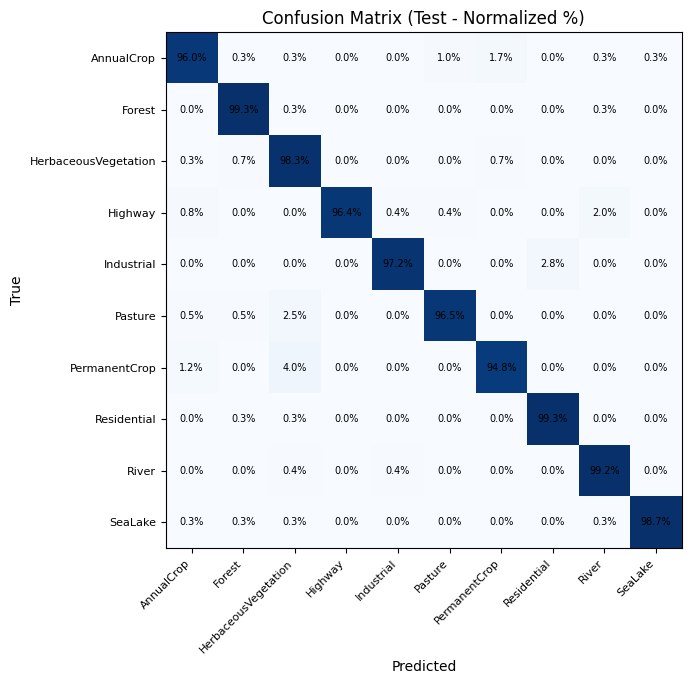

Saved: confusion_matrix_norm.png


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

classes_sorted = sorted(label2idx.keys())

# build confusion matrices
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes_sorted))))
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True).clip(min=1)

def plot_cm(mat, title, filename, cmap="Blues"):
    n = len(classes_sorted)
    plt.figure(figsize=(7, 7))
    plt.imshow(mat, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(n), classes_sorted, rotation=45, ha="right", fontsize=8)
    plt.yticks(range(n), classes_sorted, fontsize=8)
    # annotate cells
    for i in range(n):
        for j in range(n):
            val = mat[i, j] if "Normalized" not in title else mat[i, j]*100
            txt = f"{val:.0f}" if "Normalized" not in title else f"{val:.1f}%"
            plt.text(j, i, txt, ha="center", va="center", fontsize=7)
    plt.tight_layout()
    plt.savefig(filename, dpi=150)
    plt.show()
    print("Saved:", filename)

plot_cm(cm, "Confusion Matrix (Test - Counts)", "confusion_matrix_raw.png")
plot_cm(cm_norm, "Confusion Matrix (Test - Normalized %)", "confusion_matrix_norm.png")


In [16]:
# ===== Continue training with bigger batch =====
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import time, torch
from pathlib import Path

# 1) dataloaders with bigger batch
BATCH_SIZE = 64          # try 64; if OOM, set 32
ACCUM_STEPS = 1          # if OOM at 64, set BATCH_SIZE=32 AND ACCUM_STEPS=2
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# 2) load best weights so far as a good starting point
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.to(DEVICE)

# 3) smaller learning rates for later fine-tuning
criterion = nn.CrossEntropyLoss()
backbone_params = [p for n,p in model.named_parameters() if not n.startswith("fc.")]
head_params     = [p for n,p in model.named_parameters() if n.startswith("fc.")]
optimizer = torch.optim.AdamW(
    [{"params": backbone_params, "lr": 5e-5},
     {"params": head_params,     "lr": 5e-4}],
    weight_decay=1e-4
)
EXTRA_EPOCHS = 6
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EXTRA_EPOCHS)

scaler = GradScaler(enabled=(DEVICE=="cuda"))
best_val_acc = 0.0
CKPT_DIR = Path("checkpoints"); CKPT_DIR.mkdir(exist_ok=True)
BEST_PATH_2 = CKPT_DIR / "best_resnet50_ft.pt"

def run_epoch_accum(dl, train_mode: bool):
    model.train(mode=train_mode)
    total, correct, loss_sum = 0, 0, 0.0
    optimizer.zero_grad(set_to_none=True)
    for step, (xb, yb) in enumerate(dl, start=1):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with torch.set_grad_enabled(train_mode):
            with autocast(enabled=(DEVICE=="cuda")):
                logits = model(xb)
                loss = criterion(logits, yb) / ACCUM_STEPS
        if train_mode:
            scaler.scale(loss).backward()
            if step % ACCUM_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)
        loss_sum += (loss.item() * ACCUM_STEPS) * yb.size(0)
    return loss_sum/total, correct/total

for e in range(1, EXTRA_EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch_accum(train_dl, True)
    val_loss, val_acc = run_epoch_accum(val_dl, False)
    scheduler.step()
    print(f"[FT] Epoch {e}/{EXTRA_EPOCHS} | "
          f"train {tr_loss:.4f}/{tr_acc:.3f} | "
          f"val {val_loss:.4f}/{val_acc:.3f} | "
          f"{time.time()-t0:.1f}s  | bs={BATCH_SIZE}, accum={ACCUM_STEPS}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model": model.state_dict(), "classes": sorted(label2idx.keys())}, BEST_PATH_2)
        print("  ↳ saved best:", BEST_PATH_2, f"(val_acc={best_val_acc:.3f})")


/tmp/ipython-input-547582270.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE=="cuda"))
/tmp/ipython-input-547582270.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE=="cuda")):


[FT] Epoch 1/6 | train 0.0412/0.987 | val 0.0572/0.980 | 101.9s  | bs=64, accum=1
  ↳ saved best: checkpoints/best_resnet50_ft.pt (val_acc=0.980)
[FT] Epoch 2/6 | train 0.0282/0.990 | val 0.0497/0.983 | 104.1s  | bs=64, accum=1
  ↳ saved best: checkpoints/best_resnet50_ft.pt (val_acc=0.983)
[FT] Epoch 3/6 | train 0.0228/0.993 | val 0.0618/0.980 | 102.4s  | bs=64, accum=1
[FT] Epoch 4/6 | train 0.0142/0.996 | val 0.0479/0.984 | 103.3s  | bs=64, accum=1
  ↳ saved best: checkpoints/best_resnet50_ft.pt (val_acc=0.984)
[FT] Epoch 5/6 | train 0.0103/0.997 | val 0.0477/0.985 | 104.6s  | bs=64, accum=1
  ↳ saved best: checkpoints/best_resnet50_ft.pt (val_acc=0.985)
[FT] Epoch 6/6 | train 0.0074/0.998 | val 0.0440/0.988 | 103.7s  | bs=64, accum=1
  ↳ saved best: checkpoints/best_resnet50_ft.pt (val_acc=0.988)


In [17]:
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report

# pick the latest best (fallback to the first one if needed)
BEST = Path("checkpoints") / "best_resnet50_ft.pt"
if not BEST.exists():
    BEST = Path("checkpoints") / "best_resnet50.pt"
print("loading:", BEST)

ckpt = torch.load(BEST, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        logits = model(xb)
        y_pred.extend(logits.argmax(1).cpu().numpy().tolist())
        y_true.extend(yb.numpy().tolist())

test_acc = (np.array(y_true) == np.array(y_pred)).mean()
print(f"TEST accuracy: {test_acc:.4f}\n")

classes_sorted = sorted(label2idx.keys())
report = classification_report(y_true, y_pred, target_names=classes_sorted, digits=3)
print(report)

# save a copy
Path("artifacts").mkdir(exist_ok=True)
(Path("artifacts") / "test_report.txt").write_text(report)
print("Saved: artifacts/test_report.txt")


loading: checkpoints/best_resnet50_ft.pt
TEST accuracy: 0.9874

                      precision    recall  f1-score   support

          AnnualCrop      0.977     0.977     0.977       300
              Forest      1.000     0.990     0.995       300
HerbaceousVegetation      0.965     0.997     0.980       300
             Highway      0.988     0.984     0.986       250
          Industrial      0.992     0.992     0.992       250
             Pasture      0.980     0.965     0.972       200
       PermanentCrop      0.992     0.972     0.982       250
         Residential      0.993     0.997     0.995       300
               River      0.988     0.996     0.992       250
             SeaLake      1.000     0.997     0.998       300

            accuracy                          0.987      2700
           macro avg      0.987     0.987     0.987      2700
        weighted avg      0.988     0.987     0.987      2700

Saved: artifacts/test_report.txt


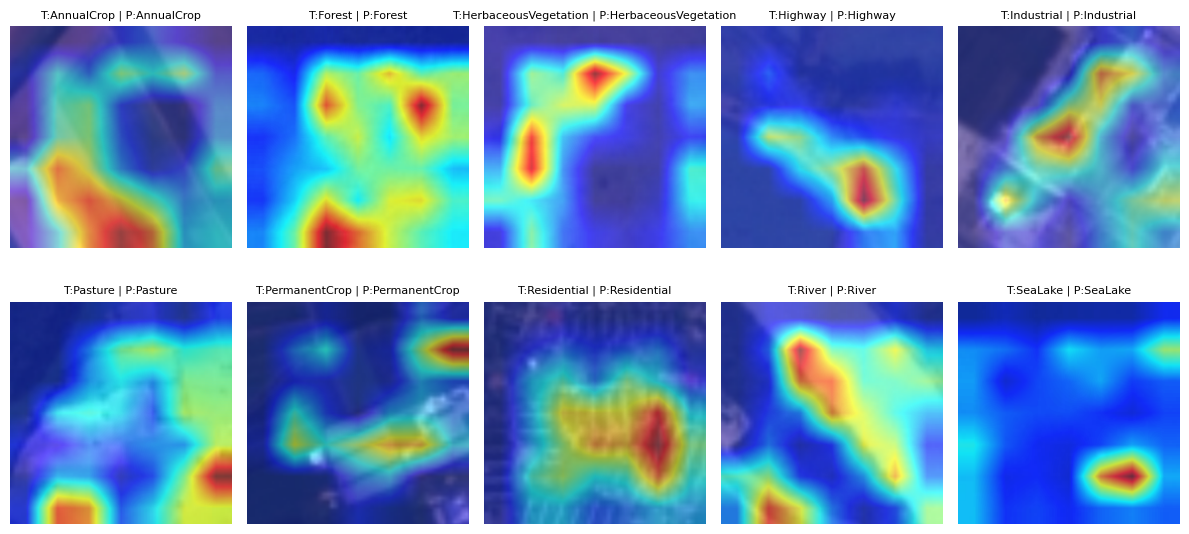

Saved overlays to: /content/gradcam


In [22]:
# Grad-CAM overlays (API without use_cuda)
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# pick the last block of ResNet-50
target_layers = [model.layer4[-1]]

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])
def denorm(t):  # t: torch tensor [3,H,W] normalized
    x = t.detach().cpu().numpy()
    x = (np.transpose(x, (1,2,0)) * IMAGENET_STD + IMAGENET_MEAN).clip(0,1)
    return x

# choose 1 sample per class from the test split
samples = []
for c in sorted(label2idx.keys()):
    row = test[test["label"]==c].sample(1, random_state=42).iloc[0]
    samples.append((row["filepath"], c))

out_dir = Path("gradcam"); out_dir.mkdir(exist_ok=True)

model.eval()
fig_cols = 5
fig_rows = (len(samples) + fig_cols - 1) // fig_cols
plt.figure(figsize=(12, 6))

# use context manager so buffers are cleaned up properly
with GradCAM(model=model, target_layers=target_layers) as cam:
    for i, (path, true_lbl) in enumerate(samples, 1):
        img_pil = Image.open(path).convert("RGB")
        x = eval_tf(img_pil).unsqueeze(0).to(DEVICE)

        # predict class
        with torch.no_grad():
            logits = model(x)
            pred_idx = int(logits.argmax(1).item())

        # compute Grad-CAM for predicted class
        grayscale_cam = cam(input_tensor=x, targets=[ClassifierOutputTarget(pred_idx)])[0]

        # overlay
        vis_rgb = denorm(x[0])
        overlay = show_cam_on_image(vis_rgb, grayscale_cam, use_rgb=True)

        # save + show
        fname = f"{i:02d}_{true_lbl}_pred_{sorted(label2idx.keys())[pred_idx]}.png"
        Image.fromarray(overlay).save(out_dir / fname)

        ax = plt.subplot(fig_rows, fig_cols, i)
        ax.imshow(overlay)
        ax.set_title(f"T:{true_lbl} | P:{sorted(label2idx.keys())[pred_idx]}", fontsize=8)
        ax.axis("off")

plt.tight_layout(); plt.show()
print("Saved overlays to:", out_dir.resolve())


In [23]:
from pathlib import Path
import torch, json

# pick the finetuned best if it exists
BEST = Path("checkpoints") / "best_resnet50_ft.pt"
if not BEST.exists():
    BEST = Path("checkpoints") / "best_resnet50.pt"
print("loading:", BEST)

# save compact weights + class list
WEIGHTS = Path("weights"); WEIGHTS.mkdir(exist_ok=True)
OUT = WEIGHTS / "resnet50_eurosat.pt"
torch.save({"model": model.state_dict(), "classes": sorted(label2idx.keys())}, OUT)
print("saved weights to:", OUT.resolve())

# also persist label maps for the app
Path("assets").mkdir(exist_ok=True)
(Path("assets")/"label2idx.json").write_text(json.dumps(label2idx, indent=2))
print("saved label2idx to:", (Path("assets")/"label2idx.json").resolve())


loading: checkpoints/best_resnet50_ft.pt
saved weights to: /content/weights/resnet50_eurosat.pt
saved label2idx to: /content/assets/label2idx.json
